# Rotational Correction

A problem in the current code is that it relies on perfect symmetry. This can be correct using an edge detector and mapping from one slice to the next. This assumes that the angle is very small and so the difference between each edge is negligable.

In [13]:
#Imports libraries
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage import io,feature
import skimage.transform as skt

Next an image is loaded to test the edge correction facilities. The image has already been flat field corrected.

In [2]:
#Reads in image`
image = io.imread('Test_Images/processed_pencil_stack.tif')

#### Edge detection

For now two slices will be taken from the image to experiment with edge detection.

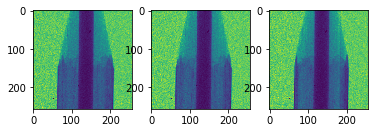

In [3]:
#Read in slices
slice1 = image[0,:,:]
slice2 = image[1,:,:]
slice10 = image[9,:,:]

#Displays the slices
_,ax = plt.subplots(1,3)
ax[0].imshow(slice1)
ax[1].imshow(slice2)
ax[2].imshow(slice10)

plt.show()

Applying edge detection with varying threshold levels. For now the canny edge detector will be used from cv2.

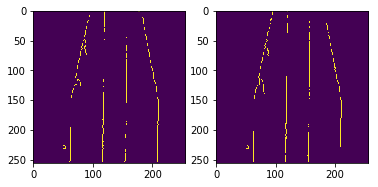

In [4]:
#Detects edges
sigma = 2
edges1 = feature.canny(slice1,sigma=sigma)
edges2 = feature.canny(slice2,sigma=sigma)

#Displays resuls
_,ax = plt.subplots(1,2)
ax[0].imshow(edges1)
ax[1].imshow(edges2)
plt.show()

#### Translational Correction

Next, a translational correction algorithm will be used on two slices comparing edge detection with no edge detection.

In [5]:
#Moves the second image so it is inline with the first image.
def lateral_correction1(img1,img2):
    
    #Defines initial variables
    trans_range = 20
    diff_ary = np.zeros(2*trans_range + 1)
    
    #Means the images to reduce noise interference
    
    #Compares img2 with img1 with different tranlations
    for i in range(-trans_range,trans_range,1):
        
        img_roll = np.roll(img2, i)
        diff_ary[i] = np.mean(np.abs(img1 - img_roll))
        
    diff_index = np.argmin(diff_ary) - trans_range
        
    return diff_index
    
  

In [6]:
lateral_correction1(slice1,slice10)

0

Now exploring the capabilites of rotational correction.

In [7]:
def rotational_correction(img1,img2):
    
    #Defines initial variables
    rot_range = 2
    dtheta = 0.1
    rot_ary = np.arange(-rot_range,rot_range,dtheta)
    diff_ary = np.zeros(len(rot_ary))
    
    #Filters the images
    flt_size = 5
    img1 = ndi.filters.median_filter(img1,size=flt_size)
    img2 = ndi.filters.median_filter(img2,size=flt_size)
    
    #Cycles through rotations
    for i in range(0,len(rot_ary)):
        
        #Rotates image
        img_rot = ndi.rotate(img2,rot_ary[i],reshape=False)
        diff_ary[i] = np.mean(np.abs(img1-img_rot))
        
    #Returns angle of minimum difference
    rot_angle = rot_ary[np.argmin(diff_ary)]
    plt.imshow(ndi.rotate(img2,rot_angle,reshape=False))
    
    return rot_angle

-0.1999999999999984

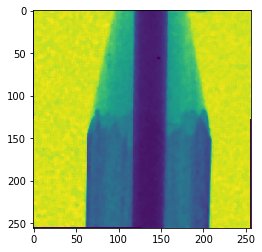

In [8]:
rotational_correction(slice1,slice2)

Next the two functions are combined to give a single slice correction function.

In [9]:
def orientation_correction(img1,img2):
    
    #Defines initial variables
    rot_range = 1
    dtheta = 0.1
    rot_ary = np.arange(-rot_range,rot_range,dtheta)
    
    trans_range = 1
    trans_ary = np.arange(-trans_range,trans_range,1)
    
    diff_ary = np.zeros((len(rot_ary),len(trans_ary)))
    
    #Detects edges of the images
#     sigma = 3
#     img1 = feature.canny(img1,sigma=sigma)
#     img2 = feature.canny(img2,sigma=sigma)
#     img1 = img1*1
#     img2 = img2*1

    #Filters image
    flt_size = 5
    img1 = ndi.filters.median_filter(img1,size=flt_size)
    img2 = ndi.filters.median_filter(img2,size=flt_size)

    #Converts to unsigned
    img1 = img1.astype('float32')
    img2 = img2.astype('float32')
    
    for i in range(0,len(trans_ary)):
        
        #Translates the image
        img_trans = np.roll(img2,trans_ary[i])
        for j in range(0,len(rot_ary)):
        
            #Rotates image
            img_rot = ndi.rotate(img_trans,rot_ary[i],reshape=False)
            diff_ary[j][i] = np.mean(np.abs(img1-img_rot))

        
    #Returns translation and angle of minimum difference
    coords = np.unravel_index(np.argmin(diff_ary),diff_ary.shape)

    return trans_ary[coords[0]],rot_ary[coords[1]]

In [14]:
orientation_correction(slice1,slice2)

(-1, -0.9)

For some reason the above function currently returns the lowest possible value for the translation. Will need to double check why and confirm its reliability.

# Improved reconstruction method

Currently, the program opperates through some primative rotation techniques. In this section I will explore the use of more advanced libraries to perform the task more accurately.

(360, 256, 256)


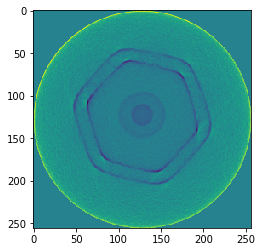

In [15]:
#Converts the image to a sinogram
angles = np.arange(0,360,1)
print(image.shape)
reconstruction = skt.iradon(ndi.rotate(image[:,200,:],90),theta=angles,circle=True)
plt.imshow(reconstruction);plt.show()

This seems to have solved the whole 3D reconstruction problem.